# Perturbation prediction benchmark

Notebook for comparing perturbation prediction.

## Library imports

In [1]:
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import perturb_prediction
from rgv_tools.core import METHOD_PALETTE_PERTURBATION

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packag

## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [3]:
DATASET = "zebrafish"

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [5]:
single_ko = ["elk3", "erf", "fli1a", "mitfa", "nr2f5", "rarga", "rxraa", "smarcc1a", "tfec", "nr2f2"]
multiple_ko = ["fli1a_elk3", "mitfa_tfec", "tfec_mitfa_bhlhe40", "fli1a_erf_erfl3", "erf_erfl3"]

In [6]:
METHODS = ["RegVelo", "Dynamo (KO)", "Dynamo (perturbation)", "celloracle"]

## Data loading

### Single knockout

In [7]:
gene_list = single_ko
perturbation = pd.read_csv(DATA_DIR / DATASET / "raw" / "df_median_meld_likelihood_new.csv")

#### predict perturbation

In [8]:
coef_perturb_co = pd.read_csv(DATA_DIR / DATASET / "results" / "celloracle_perturb_single.csv", index_col=0)
coef_perturb_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_perturb_single.csv", index_col=0)
coef_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_single.csv", index_col=0)

In [9]:
score_s = []
method = []

score_s.append(perturb_prediction(1 - coef_perturb_co, perturbation, gene_list))
method.append("celloracle")

score_s.append(perturb_prediction(coef_perturb_dyn, perturbation, gene_list))
method.append("Dynamo(perturbation)")

score_s.append(perturb_prediction(1 - coef_KO_dyn, perturbation, gene_list))
method.append("Dynamo(KO)")

In [10]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(DATA_DIR / DATASET / "results" / f"coef_single_regvelo_{nrun}", index_col=0)
    score_s.append(perturb_prediction(1 - coef_perturb_rgv, perturbation, gene_list))
    method.append("RegVelo")

### Multiple knock-out

In [11]:
gene_list = multiple_ko

#### predict perturbation

In [12]:
coef_perturb_co = pd.read_csv(DATA_DIR / DATASET / "results" / "celloracle_perturb_multiple.csv", index_col=0)
coef_perturb_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_perturb_multiple.csv", index_col=0)
coef_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_multiple.csv", index_col=0)

In [13]:
score_m = []
method = []

score_m.append(perturb_prediction(1 - coef_perturb_co, perturbation, gene_list))
method.append("celloracle")

score_m.append(perturb_prediction(coef_perturb_dyn, perturbation, gene_list))
method.append("Dynamo (perturbation)")

score_m.append(perturb_prediction(1 - coef_KO_dyn, perturbation, gene_list))
method.append("Dynamo (KO)")

In [14]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(DATA_DIR / DATASET / "results" / f"coef_multiple_regvelo_{nrun}", index_col=0)
    score_m.append(perturb_prediction(1 - coef_perturb_rgv, perturbation, gene_list))
    method.append("RegVelo")

## Plot benchmark results

In [15]:
dat = pd.DataFrame({"spearman_correlation": score_s, "method": method})
dat2 = pd.DataFrame({"spearman_correlation": score_m, "method": method})
dat["Experimental class"] = "Single TF knock-out"
dat2["Experimental class"] = "Multiple TF knock-out"
df = pd.concat([dat, dat2], axis=0)

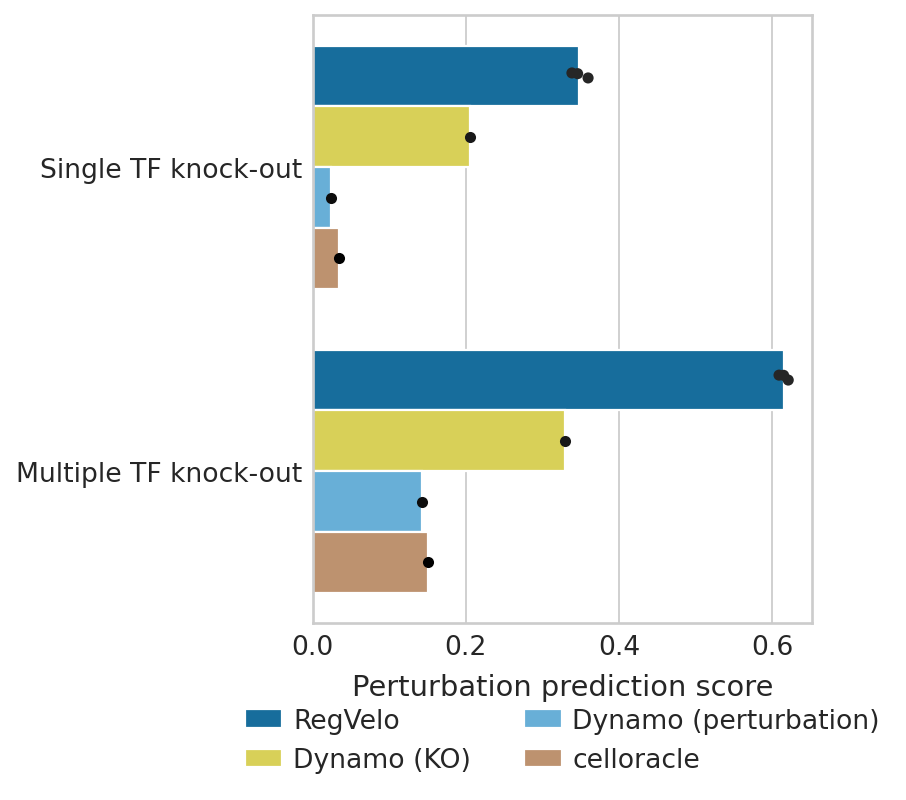

In [16]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 5))

    # Plot the barplot without error bars
    sns.barplot(
        data=df,
        y="Experimental class",
        x="spearman_correlation",
        hue="method",
        hue_order=METHODS,
        palette=METHOD_PALETTE_PERTURBATION,
        ax=ax,
        ci=None,
    )

    # Add jittered dots
    sns.stripplot(
        data=df,
        y="Experimental class",
        x="spearman_correlation",
        hue="method",
        hue_order=METHODS,
        dodge=True,
        color="black",
        ax=ax,
        jitter=True,
    )

    # Remove the duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[4 : (4 + len(METHOD_PALETTE_PERTURBATION))],
        labels[4 : (4 + len(METHOD_PALETTE_PERTURBATION))],
        bbox_to_anchor=(0.5, -0.1),
        loc="upper center",
        ncol=2,
    )

    # Customize labels and other settings
    ax.set(ylabel="", xlabel="Perturbation prediction score")
    ax.set_xlabel(xlabel="Perturbation prediction score", fontsize=13)

    if SAVE_FIGURES:
        plt.savefig(
            FIG_DIR / DATASET / "barplot_joint_knockout_update.svg", format="svg", transparent=True, bbox_inches="tight"
        )
    plt.show()

## Comparison

In [17]:
fc = score_s[3:] / score_s[2]
scipy.stats.ttest_ind(fc, fc * 0, equal_var=False, alternative="greater")

Ttest_indResult(statistic=56.317040250321945, pvalue=0.00015757416743719248)

In [18]:
fc = score_m[3:] / score_m[2]
scipy.stats.ttest_ind(fc, fc * 0, equal_var=False, alternative="greater")

Ttest_indResult(statistic=177.1021950739177, pvalue=1.5940478258249345e-05)

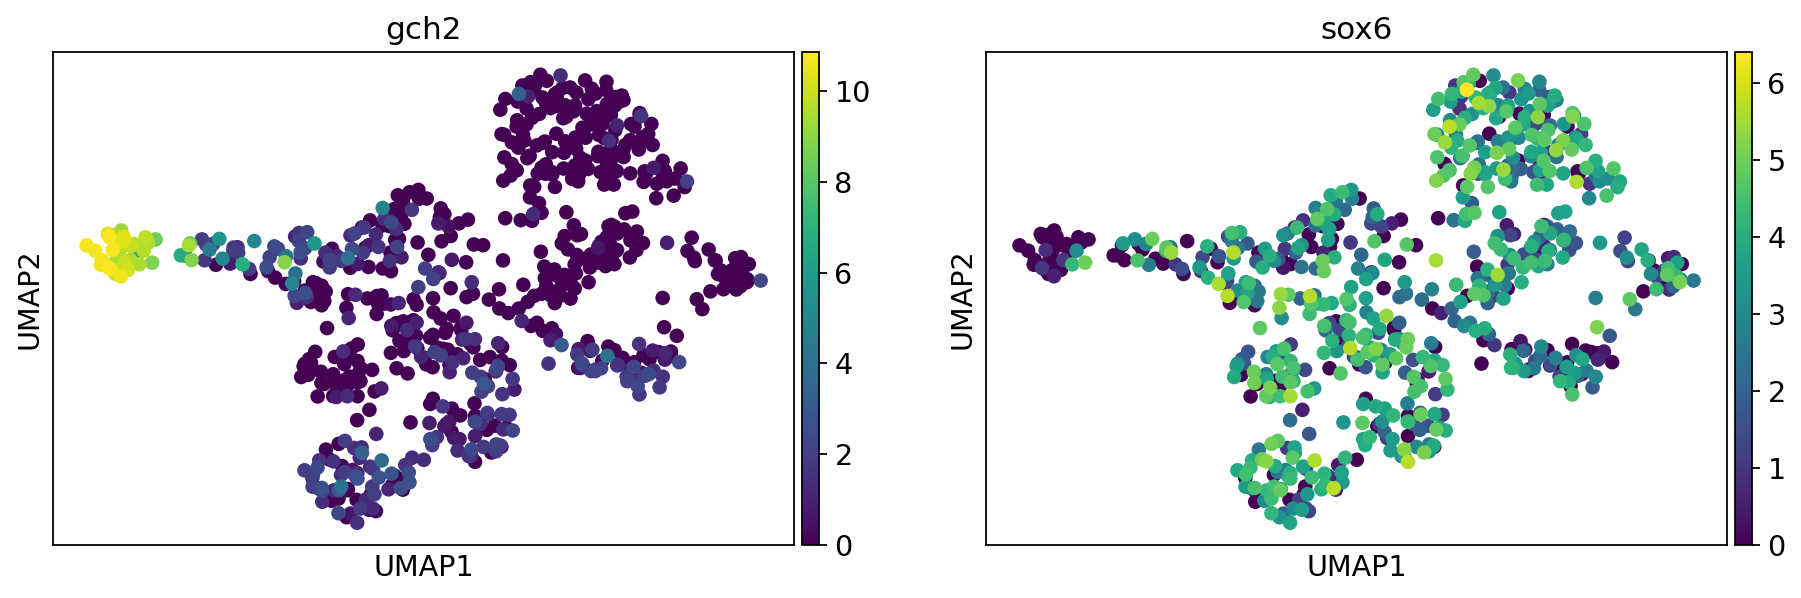

In [19]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")
sc.pl.umap(adata, color=["gch2", "sox6"])